In [1]:
import numpy as np
np.random.seed(10)
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#skin dataset - 3 features and 1 target
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
skin_data_raw = pd.read_csv(url,sep='\t',names=['x1','x2','x3','target'])

In [3]:
skin_data_raw['target'].unique()

array([1, 2], dtype=int64)

In [4]:
skin_data_raw['target']=skin_data_raw['target'].map({1:0,2:1})

In [5]:
skin_data_raw.head()

,x1,x2,x3,target
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [6]:
skin_data_raw['target'].unique()

array([0, 1], dtype=int64)

In [7]:
len(skin_data_raw['x1'].unique())

256

In [8]:
X = skin_data_raw.values[:,:3]
y = skin_data_raw.values[:,3]

In [9]:
#X_test,y_test used for final model evaluation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)
#creating a second subset of the training_data for the second model in the ensamble (logit)
X_train_rf, X_train_lr, y_train_rf, y_train_lr = train_test_split(X_train,y_train,test_size=0.5,random_state=0)

In [10]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding,RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline, Pipeline

In [11]:
n_estimators = 10

In [12]:
#unsupervised transformation using totally random trees
rt = RandomTreesEmbedding(max_depth=3,n_estimators = n_estimators, random_state = 0)
lm = LogisticRegression()
rt_lm_pipe = make_pipeline(rt,lm)
rt_lm_pipe.fit(X_train,y_train)
y_pred_rt_lm = rt_lm_pipe.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt_lm)

In [13]:
#supervised transformation using random forest
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimators)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train_rf,y_train_rf)
rf_enc.fit(rf.apply(X_train_rf))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)),y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:,1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [14]:
#using gradient boosting plus a logistic regression
grd = GradientBoostingClassifier(n_estimators = n_estimators)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train_rf,y_train_rf)
grd_enc.fit(grd.apply(X_train_rf)[:,:,0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:,:,0]),y_train_lr)
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:,:,0]))[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

In [15]:
%pdb off

Automatic pdb calling has been turned OFF


In [16]:
#grd_lm_pipe = Pipeline([('gradient_boost',GradientBoostingClassifier(n_estimators=n_estimators)),
#                        ('one_hot_encoder',OneHotEncoder),
#                        ('logit',LogisticRegression)])
#grd_lm_pipe.fit(X_train_rf,y_train_rf)

In [17]:
#Gradient boosted model by itself
grd.fit(X_train,y_train)
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

In [18]:
#Random forest by itself
rf.fit(X_train,y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [19]:
#Linear Regression by itself
lm.fit(X_train,y_train)
y_pred_lm = lm.predict_proba(X_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)

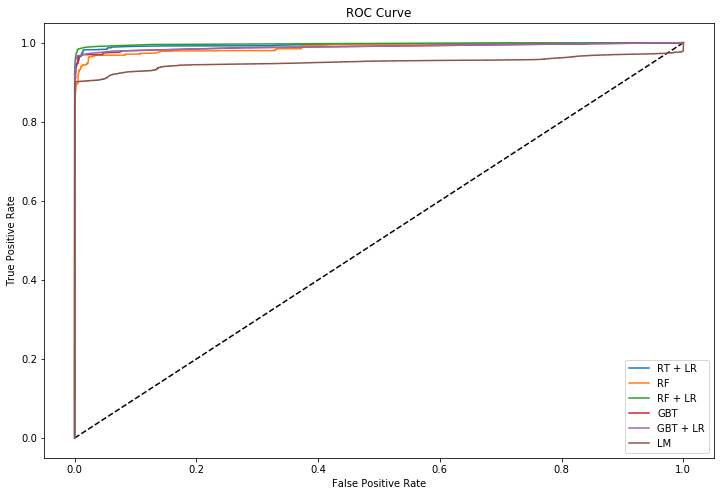

In [20]:
#plotting the results
plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.plot(fpr_lm,tpr_lm,label='LM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

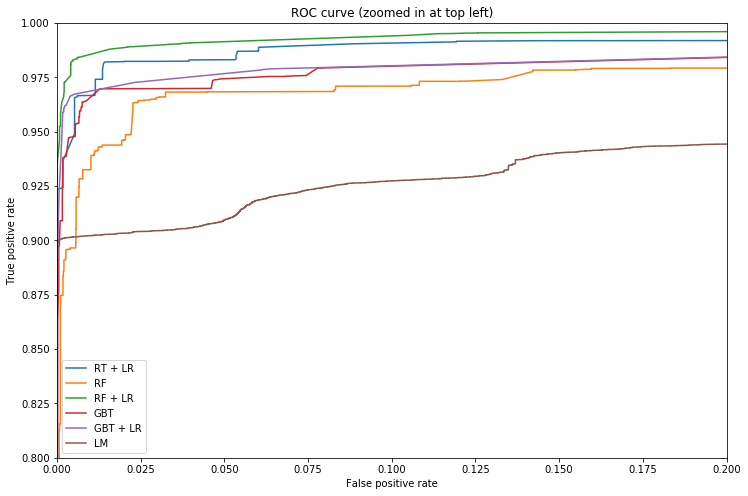

In [21]:
plt.figure(figsize=(12,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.plot(fpr_lm,tpr_lm,label='LM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [22]:
rf_lm

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
from tree_feature_transformation_v1 import TreeTransformClf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
#rf_lm2 = TreeTransformClf(tree_clf=RandomForestClassifier())
#rf_lm2 = TreeTransformClf(RandomForestClassifier(n_estimators=10,max_depth=3))
param_dict = {'n_estimators':10,
              'max_depth':3}
rf_lm2 = TreeTransformClf(RandomForestClassifier,tree_params=param_dict,logit_C=0.1)
rf_lm2.fit(X_train,y_train)

In [72]:
rf_lm==rf_lm2

False

In [73]:
y_pred_rf_lm

array([ 0.99978438,  0.03087609,  0.99999796, ...,  0.99999946,
        0.99973654,  0.99994081])

In [74]:
rf_lm2.predict_proba(X_test)[:,1]

array([ 0.99997499,  0.05135079,  0.99979106, ...,  0.99997499,
        0.99907975,  0.99985537])

In [75]:
rf_lm2.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [76]:
rf_lm2.tree_clf==RandomForestClassifier()

False

In [77]:
rt.fit(X_train,y_train)

RandomTreesEmbedding(max_depth=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, random_state=0, sparse_output=True,
           verbose=0, warm_start=False)

In [78]:
rt.fit_transform(X_train,y_train)

<164188x80 sparse matrix of type '<class 'numpy.float64'>'
	with 1641880 stored elements in Compressed Sparse Row format>

In [79]:
rtemb = TreeTransformClf(RandomTreesEmbedding,tree_params=param_dict)

In [80]:
rtemb.fit(X_train,y_train)

In [81]:
rtemb.predict_proba(X_test)[:,1]

array([ 0.99813139,  0.00202054,  0.92805888, ...,  0.99998372,
        0.99984602,  1.        ])

In [82]:
rtemb.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [83]:
param_dict = {'n_estimators':10}
grad_b = TreeTransformClf(GradientBoostingClassifier,tree_params=param_dict)

In [84]:
grad_b.fit(X_train,y_train)

In [85]:
grad_b.predict_proba(X_test)[:,1]

array([ 0.9999842 ,  0.06581308,  0.99709056, ...,  0.9999842 ,
        0.99971371,  0.99971371])

In [86]:
grad_b.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [116]:
#Tree Embedding
param_dict = {'n_estimators':10,
              'max_depth':3}
rt_model = TreeTransformClf(RandomTreesEmbedding,tree_params=param_dict,logit_C=0.1)
rt_model.fit(X_train,y_train)
rt_pred = rt_model.predict_proba(X_test)[:,1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, rt_pred)

In [117]:
#Random Forest
rf_model = TreeTransformClf(RandomForestClassifier,tree_params=param_dict,logit_C=0.1)
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict_proba(X_test)[:,1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, rf_pred)

In [118]:
#Gradient Boosting
param_dict = {'n_estimators':10}
gb_model = TreeTransformClf(GradientBoostingClassifier,tree_params=param_dict,logit_C=0.1)
gb_model.fit(X_train,y_train)
gb_pred = gb_model.predict_proba(X_test)[:,1]
fpr_gb_lm, tpr_gb_lm, _ = roc_curve(y_test, gb_pred)

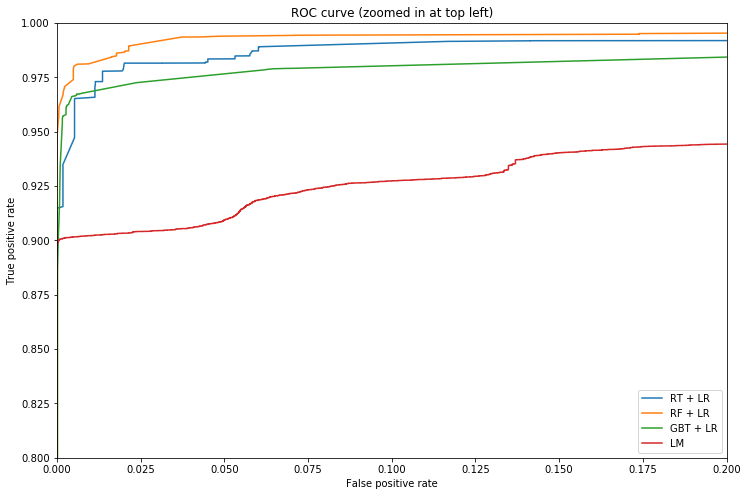

In [119]:
plt.figure(figsize=(12,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_gb_lm, tpr_gb_lm, label='GBT + LR')
plt.plot(fpr_lm,tpr_lm,label='LM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc=4)
plt.show()